### Short description about attempt/idea

### Import libraries

In [19]:
# import dependencies
from torchvision import transforms
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
# from datasets.custom_transforms import unNormalize, decode_segmap

###  Dataset reader

In [7]:
from datasets import cityscapes

In [8]:
# data directory path
data_dir = '../datasets/cityscapes/'
# for augmentation
base_size = 288 # original image resize to 'base_size' dim
crop_size = 256 # finally a random crop is performed and image of 'crop_size' dim is returned

In [9]:
# dataset readers
# additional augmentations are defined inside the reader
dst_train = cityscapes.CityscapesSegmentation(crop_size, base_size, root=data_dir, split='train')

Found 2975 train images


In [10]:
dst_val = cityscapes.CityscapesSegmentation(crop_size, base_size, root=data_dir, split='val')

Found 500 val images


### Dataloader

In [11]:
bs = 16#42 # maximum possible with image resolution, model size and available
cls_num = 19 # ignoring rare classes which cause class imbalance problem
#Dataloaders
train_loader = DataLoader(dst_train, batch_size=bs, shuffle=True)
val_loader = DataLoader(dst_val, batch_size=bs,shuffle=False)

### Model

In [12]:
# import model
from models.networkT3 import DeepLab

In [13]:
# define which gpu to use
device = torch.device("cuda:6")

In [14]:
# create instance of model
model = DeepLab(num_classes=cls_num)

Downloading: "https://github.com/zhanghang1989/ResNeSt/archive/master.zip" to /home/nipa00002/.cache/torch/hub/master.zip
Using cache found in /home/nipa00002/.cache/torch/hub/zhanghang1989_ResNeSt_master


### Hyper parameters

In [15]:
epochs = 2
lr = 3e-4
mlr = 1e-2
wdk = 4e-5

In [16]:
from torch.optim import Adam, lr_scheduler
# loss function
criterion = torch.nn.CrossEntropyLoss(size_average=True, ignore_index=255) # 255 label assigned to ignored classes
# optimizer
optimizer = Adam(model.parameters(), mlr, (0.9, 0.999),  eps=1e-08, weight_decay=wdk)
# learning rate scheduler (update after every batch)
scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=mlr, steps_per_epoch=len(train_loader), epochs=epochs)

/opt/conda/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


### Model Training

In [14]:
from utils.learn import train_val_loop

model = model.to(device)

loss_train = []
loss_val = []

loss_train, loss_val = train_val_loop(model, epochs, train_loader, val_loader, optimizer, 
                                      criterion, loss_train, 3, bs, device, scheduler)


# for epoch in range(epochs):
#     #Training
#     model.train()
#     running_loss = 0

#     for i, samples in enumerate(train_loader):
#         inputs = samples['image'].to(device)
#         labels = samples['label'].to(device).long()
#         # labels = labels.squeeze(1
#         optimizer.zero_grad()
#         outputs = model(inputs)

#         loss = criterion(outputs, labels)

#         loss.backward()
#         optimizer.step()
#         ###accumulating loss for each batch
#         running_loss += loss.item()
#         # changing LR
#         scheduler.step()

#         if i%60 == 0:
#             print("epoch{}, iter{}, running loss: {}".format(epoch, i, running_loss/(bs*(i+1))))
                  
#     loss_train.append(running_loss/len(train_loader))

#     print("epoch{}, Training loss: {}".format(epoch, running_loss/len(train_loader)))
#     torch.save(model.state_dict(), f'../weights/T3/epoch_{epoch}.pth')

#     #Validation
#     model.eval()
#     running_loss_val = 0
#     for i, samples in enumerate(val_loader):
#         inputs = samples['image'].to(device)
#         labels = samples['label'].to(device).long()
#         # labels = labels.squeeze(1)
             
#         with torch.no_grad(): 
#             outputs = model(inputs)
#             # loss = criterion(outputs,labels.long())
#             loss = criterion(outputs,labels)

#             ###accumulating loss for each batch
#             running_loss_val += loss.item()


#         #if i%10 == 0:
#     loss_val.append(running_loss_val/len(val_loader))
#     print("epoch{}, Validation loss: {}".format(epoch, running_loss_val/len(val_loader)))


KeyboardInterrupt: 

In [ ]:
# plot loss curves
x = range(epochs)
plt.title("Plot showing training and validation loss against number of epochs")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.plot(x, loss_train, color='b', label='Training loss')
plt.plot(x, loss_val, color='r', label='Validation loss')
plt.legend()
plt.savefig('results/T3_loss_curves.png', bbox_inches='tight')
plt.show()

## Visualize results

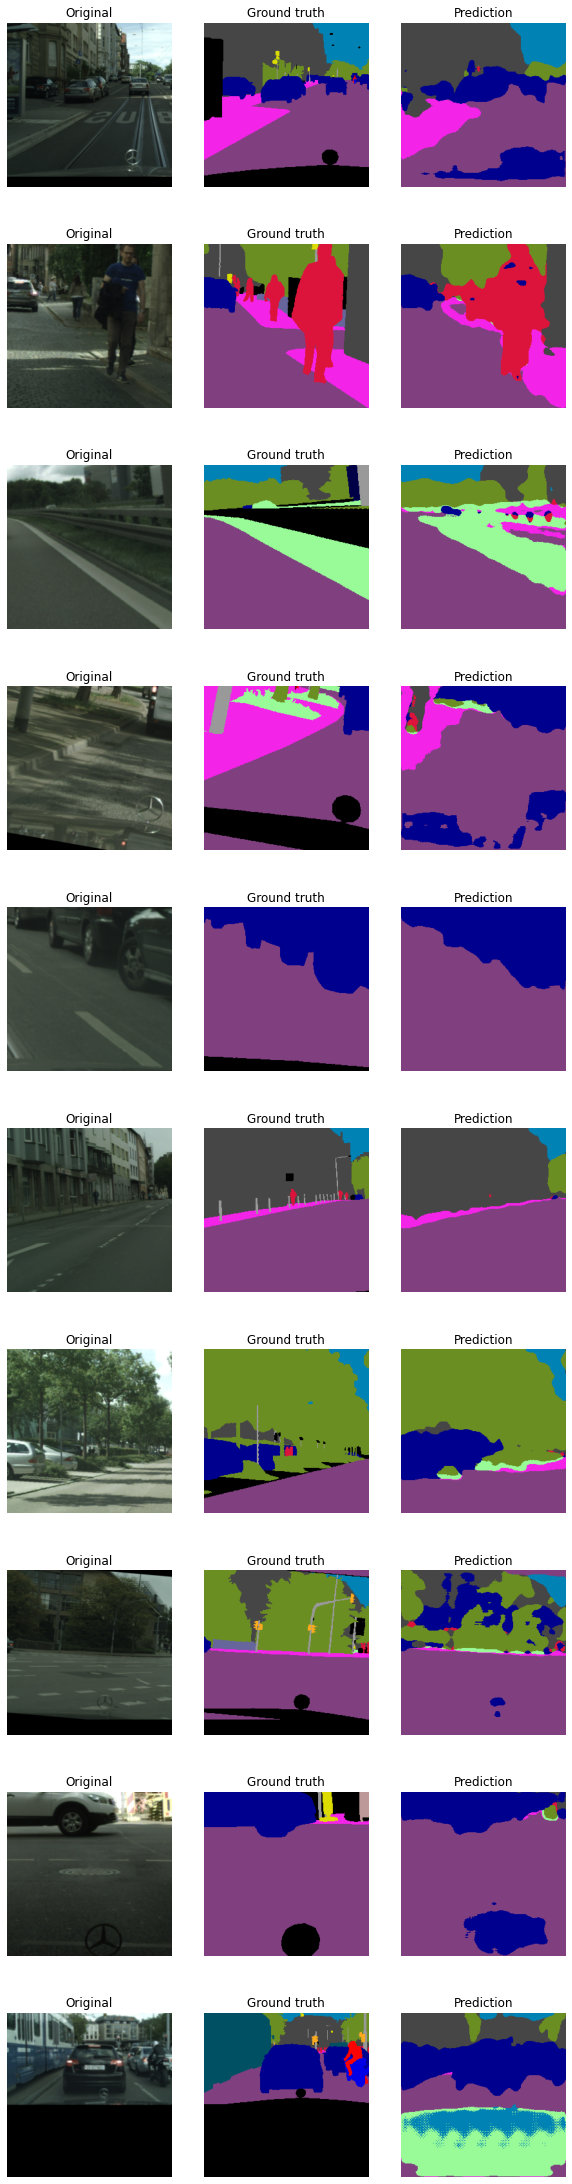

In [15]:
from utils.visual_results import visualize
# epochs=1
# move model to gpu
model = model.to(device)
# load the model states
model.load_state_dict(torch.load(f'../weights/T3/epoch_{epochs-1}.pth'))
# perform visualization
visualize(model, train_loader, 'results/T3 results.png', device)

### Evaluate the model

In [17]:
from utils.eval_metrics import evaluation_loop

evaluation_loop(model, val_loader, epochs, device, task=3)

# #6 evaluation matrices to be used: sensitivity, specificity, accuracy, AUC, DC and IOU
# from utils.eval_metrics import dice_coefficient_custom, roc_auc_custom, accuracy_se_sp_custom, sensitivity_custom, specificity_custom, iou_custom# user defined
# from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, multilabel_confusion_matrix

# def evaluate_batch(gnd_b, pred_b, cls:int = 19):
#     """
#         Calculate evalution scores over the batch.
#     Args:   
#         gnd_b: BxHxW tensor; ground truth labels; each element of matrix in B dim contains class label
#         pred_b: BxCxHxW tensor; each element contains predicted class label 
#                 here C=19 (0-18; no. of classes); each C corresponds to probabilites for that class,
#                 eg. C=0 contain score at each element in matrix HxW 
#     Return:
#         sensitivity, specificity, accuracy, aauc_score, dice_coeeficient, IOU (Intersection over union) (averaged over batch size)
#     """
#     # to cpu and as numpy ndarray
#     gnd_b = gnd_b.cpu()

#     batch_size = gnd_b.shape[0]
    
#     # extract most probable class through C-dim 
#     label_b = torch.argmax(pred_b, dim=1).cpu()
#     sensitivity = specificity = accuracy = auc = dice = iou = 0
#     # iterate over batch elements
#     for i in range(batch_size):
#         gnd = gnd_b[i,:,:] 
#         label = label_b[i,:,:]
#         #f1 += f1_score(gnd.flatten(), label.flatten(), average='micro')
#         #sensitivity += sensitivity_custom(gnd, label)
        
#         #specificity += specificity_custom(gnd, label)
#         #accuracy += accuracy_se_sp_custom(gnd, label)
#         temp = accuracy_se_sp_custom(gnd, label)
#         accuracy += temp[0]
#         sensitivity += temp[1]
#         specificity += temp[2]
#         # auc += roc_auc_score(gnd.flatten(), label.flatten(), average='micro', multi_class='ovr')
#         auc += roc_auc_custom(gnd.numpy(), label.numpy(), cls, average='macro')
#         dice += dice_coefficient_custom(gnd.numpy(), label.numpy(), cls)
#         iou += iou_custom(gnd.int(), label.int(), cls)

#     return [sensitivity/batch_size, specificity/batch_size, accuracy/batch_size, auc/batch_size, dice/batch_size, iou/batch_size]

Epochs	 Sensitivity-score Specificity-score Accuracy-score ROC-AUC-score	 Dice score	 IOU score
0	 0.786			 0.178		 0.756		 0.692		 0.593		 0.195


KeyboardInterrupt: 

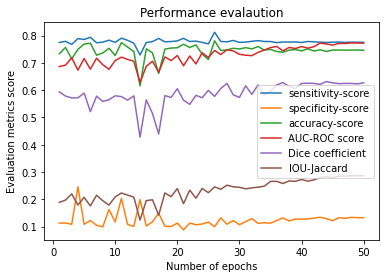

In [20]:
# PLOT
df_r = pd.read_csv('results/T3_eval.csv')

X = range(1, len(df_r)+1)
plt.plot(X, df_r.sensitivity, label="sensitivity-score")
plt.plot(X, df_r.specificity, label="specificity-score")
plt.plot(X, df_r.accuracy, label="accuracy-score")
plt.plot(X, df_r.auc, label="AUC-ROC score")
plt.plot(X, df_r.dice, label="Dice coefficient")
plt.plot(X, df_r.iou, label="IOU-Jaccard")

plt.xlabel("Number of epochs")
plt.ylabel("Evaluation metrics score")
plt.title("Performance evalaution")
plt.legend() # add legend
plt.savefig('results/T3_eval_metrics.png', bbox_inches='tight')
plt.show()